<a href="https://colab.research.google.com/github/karoldem/Rekrutacja_2023/blob/main/Rekrutacja_ko%C5%82o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First get our data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import QuantileTransformer as qt

df = pd.read_csv('https://raw.githubusercontent.com/Kolo-Naukowe-Data-Science-PW/Rekrutacja_2023/main/spaceship_titanic/dane.csv')
df['CryoSleep'] = df['CryoSleep'].astype('bool')
df['VIP'] = df['VIP'].astype('bool')
df[['Deck','CabinNum', 'Side']] = df["Cabin"].str.split("/", n = 2, expand = True)
df = df.drop('Cabin', axis=1)
df = df.drop('PassengerId', axis=1)
df = df.drop('Name', axis=1)

I expect all expenses to be "alike", so...

In [2]:
expenses = ['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
expensesBool = [ i + 'Bool' for i in expenses]
categories = ['HomePlanet', 'Destination', 'Deck', 'Side', 'CryoSleep', 'VIP', 'Transported']
nonBinaryCategories = ['HomePlanet', 'Destination']

In [3]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


Looks like 1% is making spending most of money here.

In [4]:
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNum,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,98,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1499,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,1500,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,608,S


Yes, not only 1% is spending most of money, but also seems like even touching certain area is very predictive.

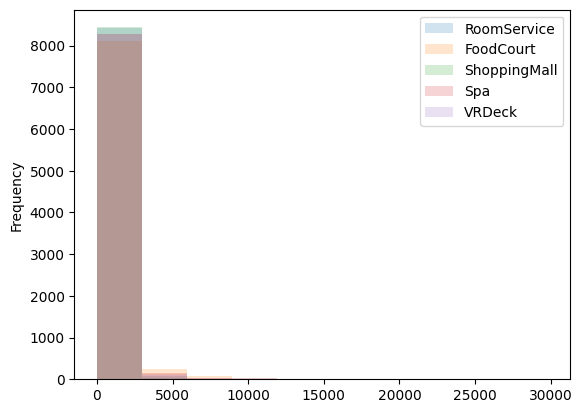

In [5]:
df[expenses].plot.hist(alpha = 0.2);

As we see, we need a logspace.

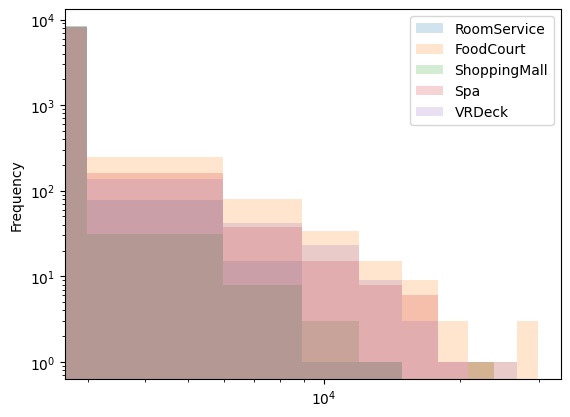

In [6]:
df[expenses].plot.hist(alpha = 0.2, logy=True, logx = True);

Now it is clearly visible that we need to get zeros into another feature and use logscale.

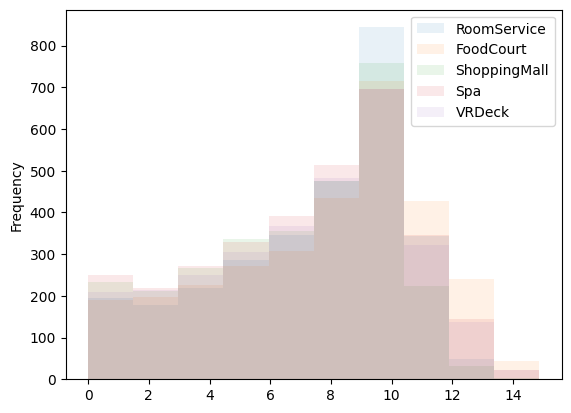

In [7]:
df1 = df.copy()

for i in expenses:
    df1[i + 'Bool'] = df1[i] > 0
    df1.loc[df1[i] == 0, [i]] = None
    df1[i] = np.log2(df1[i])

df1[expenses].plot.hist(alpha = 0.1);

In [ ]:
df[['Age']].plot.hist(alpha = 0.2, bins = 80);

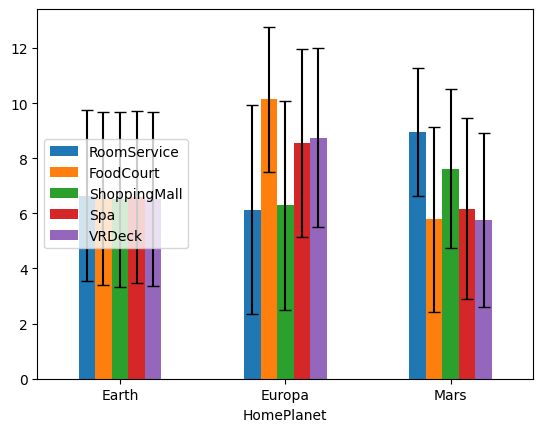

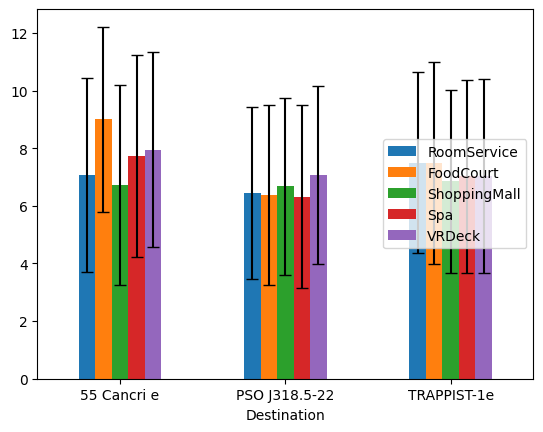

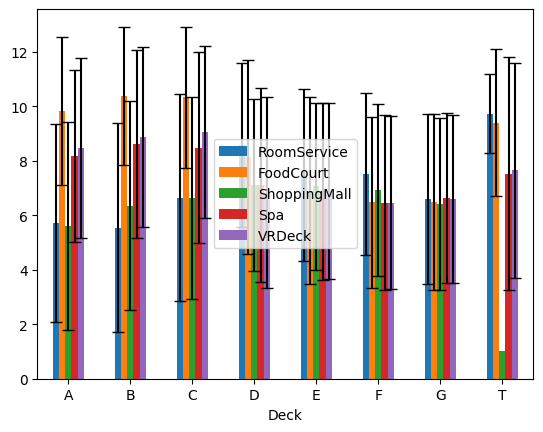

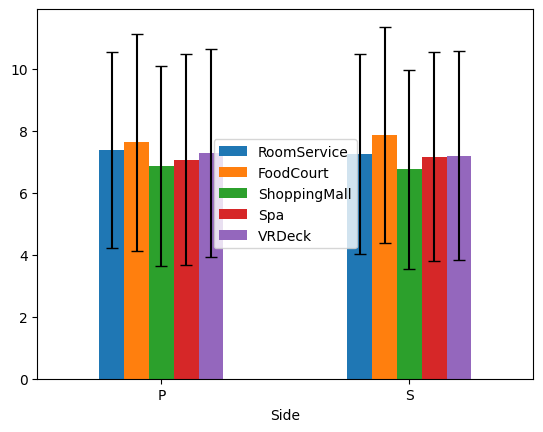

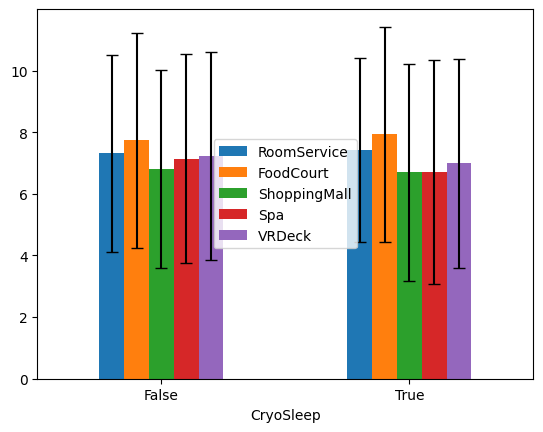

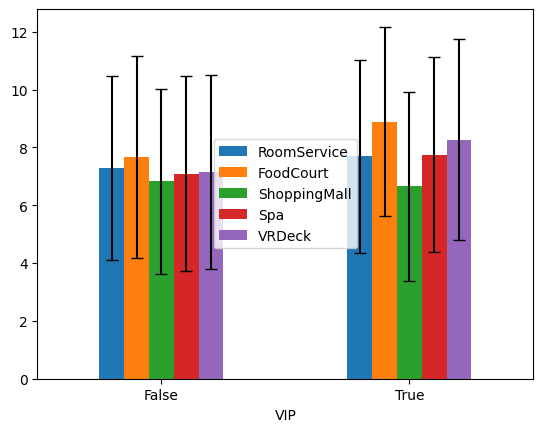

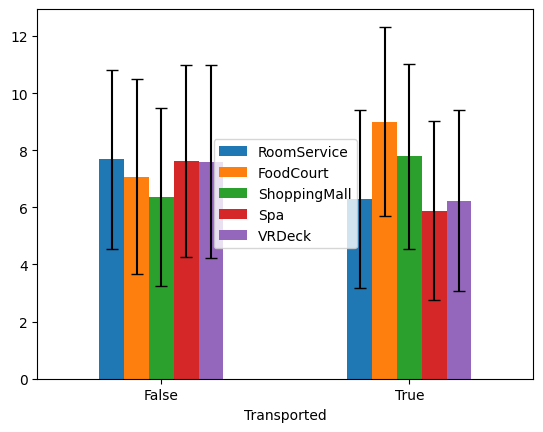

In [8]:
for i in categories:
    fig, ax = plt.subplots()
    gb = df1[([i] + expenses)].groupby([i])
    gb.mean().plot.bar(yerr=gb.std(), ax=ax, capsize=4, rot=0);

This Deck variable looks linar. Let's linearize it.

In [9]:
df['Deck'] = df['Deck'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8})

In [10]:
df['Deck'].value_counts()

6.0    2794
7.0    2559
5.0     876
2.0     779
3.0     747
4.0     478
1.0     256
8.0       5
Name: Deck, dtype: int64

OK, now data looks nice, but there's a lot of NaNs in it. Let's put them back.

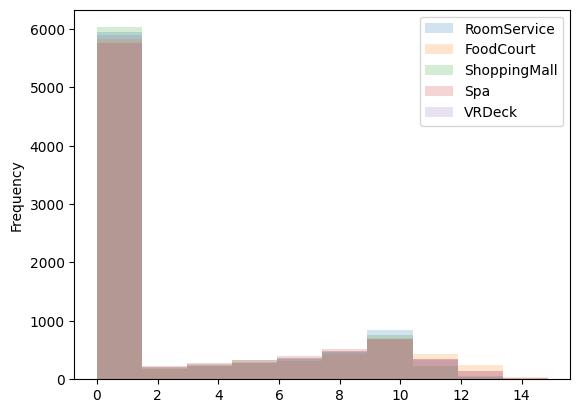

In [11]:
df1 = df.copy()
for i in expenses:
    df1[i + 'Bool'] = df1[i] > 0
    df1.loc[df1[i] == 0, [i]] = None
    df1[i] = np.log2(df1[i])
    df1.loc[df1[i].isna(), [i]] = 0

df1[expenses].plot.hist(alpha = 0.2);

Let's look at side of ship.

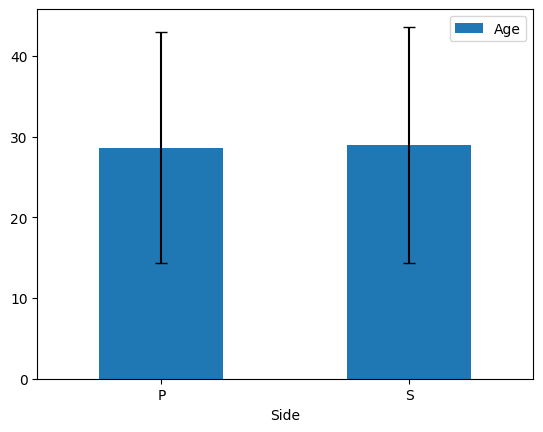

In [12]:
fig, ax = plt.subplots()
gb = df1[['Side', 'Age']].groupby(['Side'])
gb.mean().plot.bar(yerr=gb.std(), ax=ax, capsize=4, rot=0);

It looks completely random, so let's remove it from dataframe for now.

In [13]:
df1 = df1.drop('Side', axis=1)
categories.remove('Side')

Now look at categorical data.

In [14]:
i = 0
df1[[categories[i], "Transported"]].groupby([categories[i]], as_index=False).mean().sort_values(by='Transported',ascending=False)

,HomePlanet,Transported
1,Europa,0.658846
2,Mars,0.523024
0,Earth,0.423946


In [15]:
i = 1
df1[[categories[i], "Transported"]].groupby([categories[i]], as_index=False).mean().sort_values(by='Transported',ascending=False)

,Destination,Transported
0,55 Cancri e,0.610000
1,PSO J318.5-22,0.503769
2,TRAPPIST-1e,0.471175


In [16]:
i = 2
df1[[categories[i], "Transported"]].groupby([categories[i]], as_index=False).mean().sort_values(by='Transported',ascending=False)

,Deck,Transported
1,2.0,0.734275
2,3.0,0.680054
6,7.0,0.516217
0,1.0,0.496094
5,6.0,0.439871
3,4.0,0.433054
4,5.0,0.357306
7,8.0,0.200000


In [17]:
i = 3
df1[[categories[i], "Transported"]].groupby([categories[i]], as_index=False).mean().sort_values(by='Transported',ascending=False)

,CryoSleep,Transported
1,True,0.795636
0,False,0.328921


In [18]:
i = 4
df1[[categories[i], "Transported"]].groupby([categories[i]], as_index=False).mean().sort_values(by='Transported',ascending=False)

,VIP,Transported
0,False,0.506332
1,True,0.447761


Looks like thare are no more outlayers, so look at the realtions.

<ipython-input-19-58b334de199a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df1.corr())


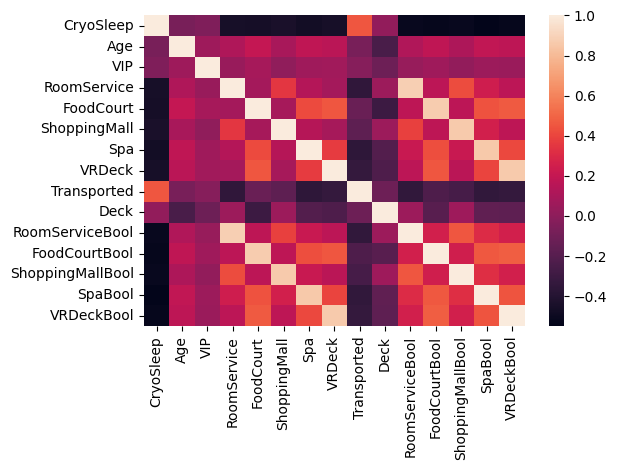

In [19]:
sns.heatmap(df1.corr())
plt.tight_layout()

Let's zoom in.

<ipython-input-20-35fa4a53fab2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df1.drop(expenses, axis=1).corr(), annot=True)


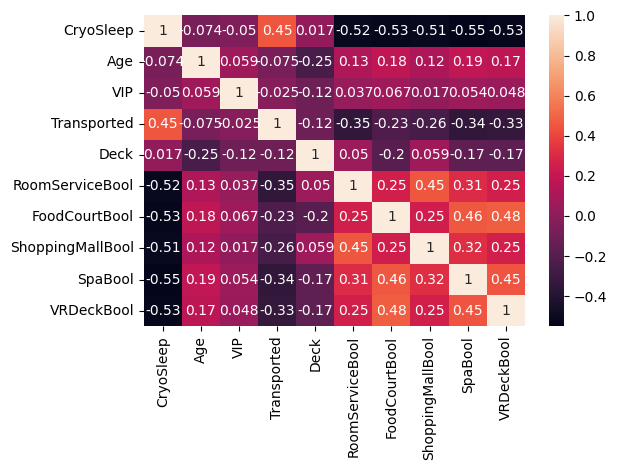

In [20]:
sns.heatmap(df1.drop(expenses, axis=1).corr(), annot=True)
plt.tight_layout()

<ipython-input-21-0de678839c37>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df1.drop(expensesBool, axis=1).corr(), annot=True)


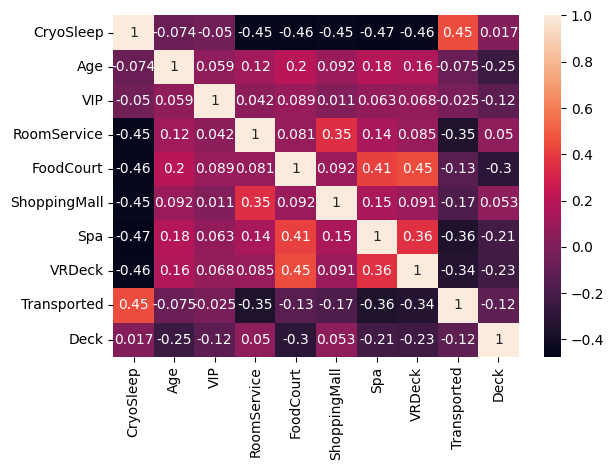

In [21]:
sns.heatmap(df1.drop(expensesBool, axis=1).corr(), annot=True)
plt.tight_layout()

Seems like boolean variables coreleate better with "Transported".

In [22]:
encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(df1[nonBinaryCategories])
temp = pd.DataFrame(encoded, columns=np.hstack(encoder.categories_))
df2 = pd.concat((df1, temp), axis=1).drop(nonBinaryCategories, axis=1)
df2 = df2.loc[:, df2.columns.notna()]
df2 = df2.dropna()

xTrain, xTest, yTrain, yTest = train_test_split(df2[df2.columns.difference(["Transported"])].values, df2['Transported'].values, test_size = 0.2)
model = DecisionTreeClassifier()
model.fit(xTrain, yTrain)
cm = confusion_matrix(yTest, model.predict(xTest))
cm = np.array((cm*100)/cm.sum(), dtype=int)
print('\n\n\n', cm[0], cm[1], cm[0][0] + cm[1][1], '\n\n\n')




 [37 13] [12 37] 74 





/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Looks decent. Now let's arbitarily cut some columns.

In [23]:
encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(df1[nonBinaryCategories])
temp = pd.DataFrame(encoded, columns=np.hstack(encoder.categories_))
df2 = pd.concat((df1, temp), axis=1).drop(nonBinaryCategories, axis=1)
df2 = df2.loc[:, df2.columns.notna()]
df2 = df2.dropna()

df2 = df2.drop(expenses, axis = 1)

xTrain, xTest, yTrain, yTest = train_test_split(df2[df2.columns.difference(["Transported"])].values, df2['Transported'].values, test_size = 0.2)
model = DecisionTreeClassifier()
model.fit(xTrain, yTrain)
cm = confusion_matrix(yTest, model.predict(xTest))
cm = np.array((cm*100)/cm.sum(), dtype=int)
print('\n\n\n', cm[0], cm[1], cm[0][0] + cm[1][1], '\n\n\n')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(





 [31 17] [16 34] 65 





I made it worse, so I should take care of these.

In [24]:
encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(df1[nonBinaryCategories])
temp = pd.DataFrame(encoded, columns=np.hstack(encoder.categories_))
df2 = pd.concat((df1, temp), axis=1).drop(nonBinaryCategories, axis=1)
df2 = df2.loc[:, df2.columns.notna()]
df2 = df2.dropna()

df2 = df2.drop(['Age'], axis = 1)

xTrain, xTest, yTrain, yTest = train_test_split(df2[df2.columns.difference(["Transported"])].values, df2['Transported'].values, test_size = 0.2)
model = DecisionTreeClassifier()
model.fit(xTrain, yTrain)
cm = confusion_matrix(yTest, model.predict(xTest))
cm = np.array((cm*100)/cm.sum(), dtype=int)
print('\n\n\n', cm[0], cm[1], cm[0][0] + cm[1][1], '\n\n\n')




 [37 12] [13 36] 73 





/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Not much of a difference.

In [25]:
encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(df1[nonBinaryCategories])
temp = pd.DataFrame(encoded, columns=np.hstack(encoder.categories_))
df2 = pd.concat((df1, temp), axis=1).drop(nonBinaryCategories, axis=1)
df2 = df2.loc[:, df2.columns.notna()]
df2 = df2.dropna()

df2 = df2.drop(['CabinNum'], axis = 1)

xTrain, xTest, yTrain, yTest = train_test_split(df2[df2.columns.difference(["Transported"])].values, df2['Transported'].values, test_size = 0.2)
model = DecisionTreeClassifier()
model.fit(xTrain, yTrain)
cm = confusion_matrix(yTest, model.predict(xTest))
cm = np.array((cm*100)/cm.sum(), dtype=int)
print('\n\n\n', cm[0], cm[1], cm[0][0] + cm[1][1], '\n\n\n')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(





 [34 14] [11 39] 73 





In [26]:
model = DecisionTreeClassifier(splitter = 'random', criterion = 'log_loss', max_features = 'log2')
model.fit(xTrain, yTrain)
cm = confusion_matrix(yTest, model.predict(xTest))
cm = np.array((cm*100)/cm.sum(), dtype=int)
print('\n\n\n', cm[0], cm[1], cm[0][0] + cm[1][1], '\n\n\n')




 [32 16] [12 38] 70 



